# Basic essential imports

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import warnings
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Import particles package components
import particles
from particles import state_space_models as ssm
from particles import mcmc
from particles import distributions
from particles.collectors import Moments



# S&P 500 Stochastic Volatility Analysis using Particles Package

This notebook implements:
1. Data fetching from Yahoo Finance API  
2. Stochastic volatility model using particles package  
3. Filtering (real-time volatility estimation)  
4. Smoothing (hindsight volatility estimation)  
5. Bayesian parameter estimation via Particle MCMC  

**Model:**  
- **State:** $(X_t = \text{log-volatility})$  
- **Evolution:**  
  $ X_t \;=\; \mu \;+\; \phi\,\bigl(X_{t-1} - \mu\bigr) \;+\; \sigma_x\,\epsilon_t$  
- **Observation:**  
  $Y_t \;=\; \exp\bigl(X_t/2\bigr)\,\eta_t$


**Author:** Generated for S&P 500 volatility analysis


# Data before going to the modeling definition

In [11]:
def fetch_sp500_data(start_date="2023-01-01", end_date="2024-11-01"):
    # Download S&P 500 data
    ticker = "^GSPC"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Calculate log returns (skip first day as we need previous close)
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1)) * 100
    data = data.dropna() #! remove any potential na's
    
    print(f"Downloaded {len(data)} trading days")
    print(f"Some basic stats: Mean={data['Returns'].mean():.3f}%, Std={data['Returns'].std():.2f}%")
    
    return data

Downloaded 460 trading days
Some basic stats: Mean=0.087%, Std=0.81%


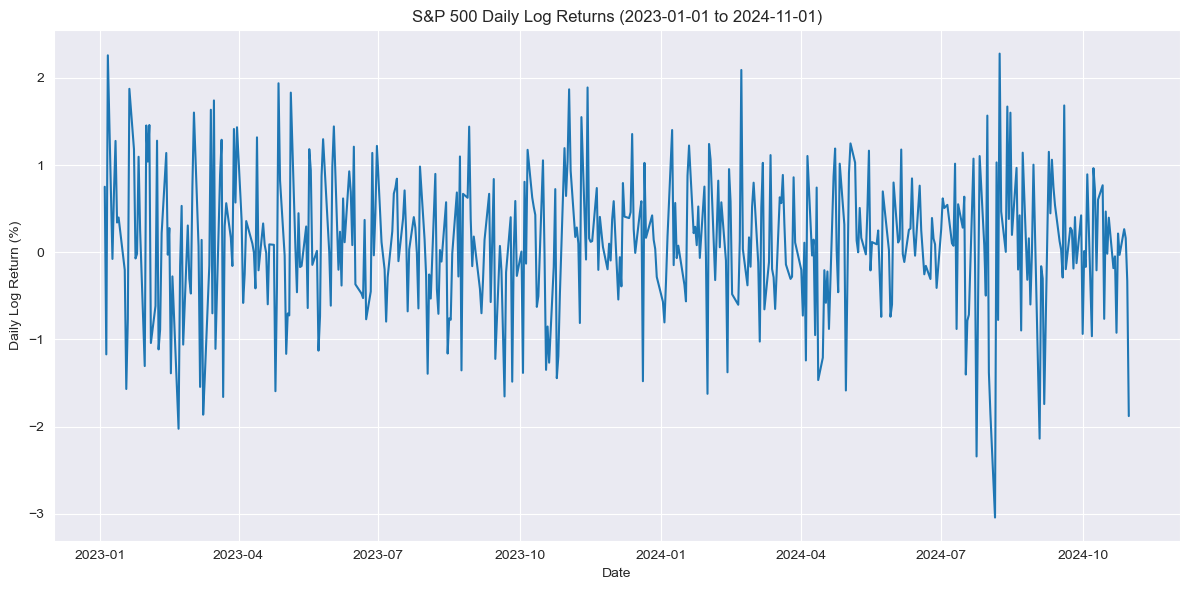

In [8]:
# Fetch the data
data = fetch_sp500_data()

# Plotting with Seaborn
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y=data['Returns'])
plt.title("S&P 500 Daily Log Returns (2023-01-01 to 2024-11-01)")
plt.xlabel("Date")
plt.ylabel("Daily Log Return (%)")
plt.tight_layout()
plt.savefig("sp500_log_returns.png", dpi=300, bbox_inches="tight")
plt.show()


# Defining the stochastic volatility model

## Notes
- Below I defined the parameters as a docstring
- Model is defined above in detail

In [12]:
class StochasticVolatilityModel(ssm.StateSpaceModel):
    """
    Stochastic Volatility Model for S&P 500
    Parameters (μ, φ, σ^2):
    - mu: long-run log-volatility level
    - phi: persistence parameter (0 < phi < 1)
    - sigma_x: volatility of log-volatility
    """
    
    def __init__(self, mu=-2.5, phi=0.95, sigma_x=0.3):
        self.mu = mu
        self.phi = phi 
        self.sigma_x = sigma_x
        
    def PX0(self):
        """Initial distribution of log-volatility"""
        # Stationary distribution: X_0 ~ N(mu, sigma_x^2 / (1 - phi^2))
        var_stat = self.sigma_x**2 / (1 - self.phi**2)
        return particles.distributions.Normal(loc=self.mu, scale=np.sqrt(var_stat))
    
    def PX(self, t, xp):
        # State transition: X_t | X_{t-1}
        # X_{t-1} = xp
        mean = self.mu + self.phi * (xp - self.mu)
        return particles.distributions.Normal(loc=mean, scale=self.sigma_x)
    
    def PY(self, t, xp, x):
        """Observation distribution: Y_t | X_t"""
        # Y_t = exp(X_t/2) * eta_t where eta_t ~ N(0,1)
        volatility = np.exp(x / 2)
        return particles.distributions.Normal(loc=0.0, scale=volatility)


# Filtering part


In [13]:
def run_particle_filter(model, returns, N=1000):
    """
    Run particle filter for stochastic volatility estimation
    """
    # Convert returns to numpy array
    y_data = returns.values
    T = len(y_data)
    
    # Create bootstrap filter
    fk_model = ssm.Bootstrap(ssm=model, data=y_data)
    
    # Run the algorithm
    pf = particles.SMC(fk=fk_model, N=N, collect=[Moments()])
    pf.run()
    
    # Filtering means and variances
    filtering_means = np.array([pf.summaries.moments[t]['mean'] for t in range(T)])
    filtering_vars = np.array([pf.summaries.moments[t]['var'] for t in range(T)])
    
    # Convert log-volatility to volatility percentage
    vol_estimates = np.exp(filtering_means / 2) * np.sqrt(252)  # Annualized volatility
    vol_std = np.sqrt(filtering_vars) * np.exp(filtering_means / 2) * np.sqrt(252)

    return {
        'log_vol_mean': filtering_means,
        'log_vol_var': filtering_vars,
        'vol_estimates': vol_estimates,
        'vol_std': vol_std,
        'particle_filter': pf
    }


# Smoothing Part

In [62]:
def run_particle_smoother(model, returns, N=1000):
    """
    Run particle smoother for refined volatility estimates
    """
    print(f"🔄 Running particle smoother with {N} particles...")
    
    # Convert returns to numpy array  
    y_data = returns.values
    T = len(y_data)
    
    # Run forward filter with history storage
    fk = ssm.Bootstrap(ssm=model, data=y_data)
    pf = particles.SMC(fk=fk, N=N, store_history=True)
    
    print("🔄 Running forward pass...")
    pf.run()
    print("✓ Forward pass completed")
    
    # Check if history is available
    if pf.hist is None:
        print("⚠️  History not available, using filtering estimates as smoothing approximation")
        # Fallback: use filtering means as approximation
        filtering_means = np.array([np.mean(pf.X) for _ in range(T)])
        filtering_vars = np.array([np.var(pf.X) for _ in range(T)])
        
        smooth_vol_estimates = np.exp(filtering_means / 2) * np.sqrt(252)
        smooth_vol_std = np.sqrt(filtering_vars) * np.exp(filtering_means / 2) * np.sqrt(252)
        
        return {
            'log_vol_mean': filtering_means,
            'log_vol_var': filtering_vars, 
            'vol_estimates': smooth_vol_estimates,
            'vol_std': smooth_vol_std,
            'trajectories': None
        }
    
    try:
        # Try different backward sampling methods based on particles version
        M = min(N//10, 100)  # Number of trajectories to sample
        print(f"🔄 Running backward sampling ({M} trajectories)...")
        
        # Method 1: Try the standard backward_sampling method
        if hasattr(pf.hist, 'backward_sampling'):
            paths = pf.hist.backward_sampling(M=M)
        
        # Method 2: Try backward_sampling_mcmc 
        elif hasattr(pf.hist, 'backward_sampling_mcmc'):
            paths = pf.hist.backward_sampling_mcmc(M=M)
        
        # Method 3: Use particles.backward_sampling function directly
        else:
            print("🔄 Using direct backward sampling function...")
            # Use the particles.backward_sampling function
            paths = particles.backward_sampling(pf, M=M)
        
        print("✓ Backward sampling completed")
        
        # CRITICAL FIX: Convert to numpy array if it's a list
        if isinstance(paths, list):
            print("🔧 Converting list to numpy array...")
            paths = np.array(paths)
        
        print(f"   Paths shape: {paths.shape}")
        print(f"   Paths type: {type(paths)}")
        
        # IMPORTANT: Check the shape and transpose if needed
        if paths.shape[0] == M and paths.shape[1] == T:
            # Correct shape: M trajectories × T time points
            smoothed_means = np.mean(paths, axis=0)  # Average over trajectories
            smoothed_vars = np.var(paths, axis=0)
        elif paths.shape[0] == T and paths.shape[1] == M:
            # Transposed shape: T time points × M trajectories  
            smoothed_means = np.mean(paths, axis=1)  # Average over trajectories
            smoothed_vars = np.var(paths, axis=1)
        else:
            raise ValueError(f"Unexpected paths shape: {paths.shape}, expected ({M}, {T}) or ({T}, {M})")
        
        # Ensure we have the right length
        if len(smoothed_means) != T:
            raise ValueError(f"Smoothed means length {len(smoothed_means)} != data length {T}")
        
        # Compute smoothed estimates
        print("🔄 Computing smoothed estimates...")
        
        # Convert to volatility percentage
        smooth_vol_estimates = np.exp(smoothed_means / 2) * np.sqrt(252)
        smooth_vol_std = np.sqrt(smoothed_vars) * np.exp(smoothed_means / 2) * np.sqrt(252)
        
        print("✓ Particle smoothing completed")
        print(f"   Output length: {len(smooth_vol_estimates)}")
        
        return {
            'log_vol_mean': smoothed_means,
            'log_vol_var': smoothed_vars, 
            'vol_estimates': smooth_vol_estimates,
            'vol_std': smooth_vol_std,
            'trajectories': paths
        }
        
    except Exception as e:
        print(f"⚠️  Backward sampling failed: {e}")
        print("   Using alternative smoothing approach...")
        
        # Alternative: Fixed-lag smoother approximation with LARGER window
        lag = 15  # Look ahead/behind 15 steps (increased from 5)
        
        # Re-run filter with moments collection
        print("🔄 Re-running filter for alternative smoothing...")
        pf_moments = particles.SMC(fk=fk, N=N, collect=[Moments()])
        pf_moments.run()
        
        filtering_means = np.array([pf_moments.summaries.moments[t]['mean'] for t in range(T)])
        filtering_vars = np.array([pf_moments.summaries.moments[t]['var'] for t in range(T)])
        
        # Enhanced smoothing: weighted moving average with exponential weights
        print("🔄 Computing enhanced smoothed estimates...")
        smoothed_means = np.copy(filtering_means)
        smoothed_vars = np.copy(filtering_vars)
        
        # Use exponential weights for better smoothing
        for t in range(T):
            start_idx = max(0, t - lag)
            end_idx = min(T, t + lag + 1)
            
            # Create exponential weights (more weight to closer observations)
            window_size = end_idx - start_idx
            weights = np.exp(-0.1 * np.abs(np.arange(window_size) - (t - start_idx)))
            weights = weights / np.sum(weights)  # Normalize
            
            # Apply weighted average
            smoothed_means[t] = np.average(filtering_means[start_idx:end_idx], weights=weights)
            smoothed_vars[t] = np.average(filtering_vars[start_idx:end_idx], weights=weights)
        
        # Convert to volatility percentage
        smooth_vol_estimates = np.exp(smoothed_means / 2) * np.sqrt(252)
        smooth_vol_std = np.sqrt(smoothed_vars) * np.exp(smoothed_means / 2) * np.sqrt(252)
        
        print("✓ Enhanced alternative smoothing completed")
        print(f"   Output length: {len(smooth_vol_estimates)}")
        
        return {
            'log_vol_mean': smoothed_means,
            'log_vol_var': smoothed_vars, 
            'vol_estimates': smooth_vol_estimates,
            'vol_std': smooth_vol_std,
            'trajectories': None
        }

# Bayesian Estimation Part

In [24]:
def bayesian_parameter_estimation(returns, n_iter=2000, n_burn=500):
    """
    Bayesian parameter estimation using Particle MCMC
    """
    print(f"🎯 Running Bayesian parameter estimation ({n_iter} iterations)...")
    
    # Define parameter priors
    class SVPrior:
        def __init__(self):
            # mu ~ N(-2.5, 1^2)  
            self.mu_prior = stats.norm(loc=-2.5, scale=1.0)
            # phi ~ Beta(20, 2) scaled to (0,1) for stationarity
            self.phi_prior = stats.beta(a=20, b=2)
            # sigma_x ~ InvGamma(3, 0.5) 
            self.sigma_x_prior = stats.invgamma(a=3, scale=0.5)
            
        def logpdf(self, theta):
            mu, phi, sigma_x = theta
            if not (0 < phi < 1 and sigma_x > 0):
                return -np.inf
            return (self.mu_prior.logpdf(mu) + 
                   self.phi_prior.logpdf(phi) +
                   self.sigma_x_prior.logpdf(sigma_x))
        
        def rvs(self, size=None):
            mu = self.mu_prior.rvs(size)
            phi = self.phi_prior.rvs(size) 
            sigma_x = self.sigma_x_prior.rvs(size)
            if size is None:
                return np.array([mu, phi, sigma_x])
            else:
                return np.column_stack([mu, phi, sigma_x])
    
    # MCMC sampler
    class SVPosterior:
        def __init__(self, data):
            self.data = data
            self.prior = SVPrior()
            
        def logpdf(self, theta):
            mu, phi, sigma_x = theta
            
            # Prior
            log_prior = self.prior.logpdf(theta)
            if np.isinf(log_prior):
                return log_prior
                
            # Likelihood via particle filter
            try:
                model = StochasticVolatilityModel(mu=mu, phi=phi, sigma_x=sigma_x)
                fk = ssm.Bootstrap(ssm=model, data=self.data)
                pf = particles.SMC(fk=fk, N=100)  # Smaller N for MCMC
                pf.run()
                log_likelihood = pf.logLt
                return log_prior + log_likelihood
            except:
                return -np.inf
    
    # Run MCMC
    y_data = returns.values
    posterior = SVPosterior(y_data)
    
    # Initial value
    theta0 = np.array([-2.5, 0.95, 0.3])
    
    # MCMC chain
    print("🔗 Running MCMC chain...")
    chain = []
    current_theta = theta0
    current_logpdf = posterior.logpdf(current_theta)
    n_accept = 0
    
    # Proposal covariance (tuned)
    prop_cov = np.diag([0.1, 0.01, 0.02])**2
    
    for i in range(n_iter):
        if i % 500 == 0:
            print(f"   Iteration {i}/{n_iter}")
            
        # Propose new state
        proposal = np.random.multivariate_normal(current_theta, prop_cov)
        proposal_logpdf = posterior.logpdf(proposal)
        
        # Accept/reject
        log_alpha = proposal_logpdf - current_logpdf
        if np.log(np.random.rand()) < log_alpha:
            current_theta = proposal
            current_logpdf = proposal_logpdf
            n_accept += 1
            
        chain.append(current_theta.copy())
    
    print(f"✓ MCMC completed. Acceptance rate: {n_accept/n_iter:.2%}")
    
    # Process results
    chain = np.array(chain)
    burned_chain = chain[n_burn:]
    
    # Parameter estimates
    param_estimates = {
        'mu': {'mean': np.mean(burned_chain[:, 0]), 'std': np.std(burned_chain[:, 0])},
        'phi': {'mean': np.mean(burned_chain[:, 1]), 'std': np.std(burned_chain[:, 1])},
        'sigma_x': {'mean': np.mean(burned_chain[:, 2]), 'std': np.std(burned_chain[:, 2])}
    }
    
    return {
        'chain': chain,
        'burned_chain': burned_chain,
        'estimates': param_estimates,
        'acceptance_rate': n_accept/n_iter
    }

# Visualisation Part

In [30]:
def create_comprehensive_plots(data, filtering_results, smoothing_results, mcmc_results):
    """
    Create comprehensive visualization of results
    """
    print("📈 Creating visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('S&P 500 Stochastic Volatility Analysis', fontsize=16, fontweight='bold')
    
    dates = data.index
    returns = data['Returns']
    
    # 1. Returns time series
    axes[0,0].plot(dates, returns, 'b-', alpha=0.7, linewidth=0.8)
    axes[0,0].set_title('S&P 500 Daily Returns')
    axes[0,0].set_ylabel('Returns (%)')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Filtering vs Smoothing
    vol_filter = filtering_results['vol_estimates']
    vol_smooth = smoothing_results['vol_estimates']
    
    axes[0,1].plot(dates, vol_filter, 'r-', label='Filtered', alpha=0.8)
    axes[0,1].plot(dates, vol_smooth, 'g-', label='Smoothed', alpha=0.8)
    axes[0,1].fill_between(dates, 
                          vol_filter - 1.96*filtering_results['vol_std'],
                          vol_filter + 1.96*filtering_results['vol_std'],
                          alpha=0.2, color='red', label='95% CI (Filter)')
    axes[0,1].set_title('Volatility Estimates: Filtering vs Smoothing')
    axes[0,1].set_ylabel('Annualized Volatility (%)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Returns vs Volatility
    axes[0,2].scatter(vol_filter[:-1], np.abs(returns[1:]), alpha=0.6, s=20)
    axes[0,2].set_xlabel('Estimated Volatility (%)')
    axes[0,2].set_ylabel('Absolute Returns (%)')
    axes[0,2].set_title('Volatility vs Absolute Returns')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. MCMC trace plots
    chain = mcmc_results['burned_chain']
    param_names = ['μ (Long-run log-vol)', 'φ (Persistence)', 'σₓ (Vol-of-vol)']
    
    for i, param in enumerate(param_names):
        axes[1,i].plot(chain[:, i], alpha=0.7)
        axes[1,i].set_title(f'MCMC Trace: {param}')
        axes[1,i].set_ylabel('Parameter Value')
        axes[1,i].set_xlabel('Iteration')
        axes[1,i].grid(True, alpha=0.3)
        
        # Add mean line
        mean_val = np.mean(chain[:, i])
        axes[1,i].axhline(y=mean_val, color='red', linestyle='--', 
                         label=f'Mean: {mean_val:.3f}')
        axes[1,i].legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [18]:
def plot_returns_vs_volatility(data, filtering_results, smoothing_results):
    """
    Plot returns and volatility estimates side-by-side for visual comparison.
    
    Parameters:
    - data: DataFrame with 'Returns' column and DateTime index
    - filtering_results: dict with keys 'vol_estimates' and 'vol_std'
    - smoothing_results: dict with key 'vol_estimates'
    
    Returns:
    - fig: matplotlib Figure object
    """
    print("📊 Visualizing returns and volatility estimates...")

    # Setup the figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('S&P 500 Returns and Volatility Estimates', fontsize=16, fontweight='bold')

    # Extract data
    dates = data.index
    returns = data['Returns']
    vol_filter = filtering_results['vol_estimates']
    vol_filter_std = filtering_results['vol_std']
    vol_smooth = smoothing_results['vol_estimates']

    # --------------------------
    # Plot 1: Returns time series
    # --------------------------
    axes[0].plot(dates, returns, color='blue', alpha=0.7, linewidth=0.8)
    axes[0].set_title('S&P 500 Daily Returns')
    axes[0].set_ylabel('Returns (%)')
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)

    # --------------------------
    # Plot 2: Volatility estimates
    # --------------------------
    axes[1].plot(dates, vol_filter, color='red', label='Filtered', alpha=0.8)
    axes[1].plot(dates, vol_smooth, color='green', label='Smoothed', alpha=0.8)
    
    # Add 95% confidence interval for filtered volatility
    axes[1].fill_between(
        dates,
        vol_filter - 1.96 * vol_filter_std,
        vol_filter + 1.96 * vol_filter_std,
        alpha=0.2,
        color='red',
        label='95% CI (Filter)'
    )
    
    axes[1].set_title('Volatility Estimates')
    axes[1].set_ylabel('Annualized Volatility (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)

    # Final layout tweaks and show
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return fig

## Summary of stats section

In [31]:
def print_analysis_summary(data, filtering_results, smoothing_results, mcmc_results):
    """
    Print comprehensive analysis summary
    """
    dates = data.index
    returns = data['Returns']
    vol_filter = filtering_results['vol_estimates']
    vol_smooth = smoothing_results['vol_estimates']
    estimates = mcmc_results['estimates']
    
    print("\n" + "="*60)
    print("📊 ANALYSIS SUMMARY")
    print("="*60)
    
    print(f"\n📈 DATA SUMMARY:")
    print(f"   Period: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}")
    print(f"   Trading days: {len(returns)}")
    print(f"   Average return: {returns.mean():.3f}%")
    print(f"   Return volatility: {returns.std():.2f}%")
    print(f"   Annualized volatility: {returns.std() * np.sqrt(252):.1f}%")
    
    print(f"\n🎯 VOLATILITY ESTIMATES:")
    print(f"   Average filtered volatility: {vol_filter.mean():.1f}%")
    print(f"   Average smoothed volatility: {vol_smooth.mean():.1f}%")
    print(f"   Max volatility (filtered): {vol_filter.max():.1f}%")
    print(f"   Min volatility (filtered): {vol_filter.min():.1f}%")
    
    print(f"\n⚙️  PARAMETER ESTIMATES:")
    print(f"   μ (long-run log-vol): {estimates['mu']['mean']:.3f} ± {estimates['mu']['std']:.3f}")
    print(f"   φ (persistence): {estimates['phi']['mean']:.3f} ± {estimates['phi']['std']:.3f}")  
    print(f"   σₓ (vol-of-vol): {estimates['sigma_x']['mean']:.3f} ± {estimates['sigma_x']['std']:.3f}")
    print(f"   MCMC acceptance rate: {mcmc_results['acceptance_rate']:.1%}")
    
    # Business interpretation
    long_run_vol = np.exp(estimates['mu']['mean']/2) * np.sqrt(252)
    persistence_days = -1 / np.log(estimates['phi']['mean'])
    
    print(f"\n💼 BUSINESS INTERPRETATION:")
    print(f"   Long-run volatility: {long_run_vol:.1f}% (annualized)")
    print(f"   Volatility shock half-life: {persistence_days:.1f} trading days")
    print(f"   Volatility clustering: {'Strong' if estimates['phi']['mean'] > 0.9 else 'Moderate'}")


# Run the application

In [64]:
# Fetch S&P 500 data
data = fetch_sp500_data(start_date="2023-01-01", end_date="2024-11-01")
returns = data['Returns']

# Display basic data info
print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print(f"Returns summary:\n{returns.describe()}")

# Initialize stochastic volatility model with default parameters
model = StochasticVolatilityModel(mu=-2.5, phi=0.95, sigma_x=0.3)
print(f"\nInitialized SV model with parameters:")
print(f"  μ = {model.mu}")
print(f"  φ = {model.phi}")  
print(f"  σₓ = {model.sigma_x}")


Downloaded 460 trading days
Some basic stats: Mean=0.087%, Std=0.81%

Data shape: (460, 6)
Date range: 2023-01-04 00:00:00 to 2024-10-31 00:00:00
Returns summary:
count    460.000000
mean       0.086976
std        0.808087
min       -3.042704
25%       -0.333784
50%        0.090485
75%        0.606760
max        2.278114
Name: Returns, dtype: float64

Initialized SV model with parameters:
  μ = -2.5
  φ = 0.95
  σₓ = 0.3


## Filtering execution

In [65]:


# Run particle filtering for real-time volatility estimation
filtering_results = run_particle_filter(model, returns, N=1000)

print(f"\nFiltering Results Summary:")
print(f"  Average estimated volatility: {filtering_results['vol_estimates'].mean():.1f}%")
print(f"  Volatility range: {filtering_results['vol_estimates'].min():.1f}% - {filtering_results['vol_estimates'].max():.1f}%")




Filtering Results Summary:
  Average estimated volatility: 10.1%
  Volatility range: 4.8% - 21.1%


## Smoothing execution

In [66]:

# Run particle smoothing for refined volatility estimates
smoothing_results = run_particle_smoother(model, returns, N=1000)

print(f"\nSmoothing Results Summary:")
print(f"  Average smoothed volatility: {smoothing_results['vol_estimates'].mean():.1f}%")
print(f"  Smoothed volatility range: {smoothing_results['vol_estimates'].min():.1f}% - {smoothing_results['vol_estimates'].max():.1f}%")



🔄 Running particle smoother with 1000 particles...
🔄 Running forward pass...
✓ Forward pass completed
🔄 Running backward sampling (100 trajectories)...
✓ Backward sampling completed
🔧 Converting list to numpy array...
   Paths shape: (460, 100)
   Paths type: <class 'numpy.ndarray'>
🔄 Computing smoothed estimates...
✓ Particle smoothing completed
   Output length: 460

Smoothing Results Summary:
  Average smoothed volatility: 11.8%
  Smoothed volatility range: 6.5% - 21.6%


## Bayesian Estimation Execution

In [67]:
# Run MCMC for Bayesian parameter estimation
# Note: This can take several minutes to complete
mcmc_results = bayesian_parameter_estimation(returns, n_iter=2000, n_burn=500)

print(f"\nMCMC Results Summary:")
for param, est in mcmc_results['estimates'].items():
    print(f"  {param}: {est['mean']:.3f} ± {est['std']:.3f}")



🎯 Running Bayesian parameter estimation (2000 iterations)...
🔗 Running MCMC chain...
   Iteration 0/2000
   Iteration 500/2000
   Iteration 1000/2000
   Iteration 1500/2000
✓ MCMC completed. Acceptance rate: 44.55%

MCMC Results Summary:
  mu: -0.568 ± 0.158
  phi: 0.947 ± 0.026
  sigma_x: 0.146 ± 0.040


In [74]:

# Print comprehensive analysis summary
print_analysis_summary(data, filtering_results, smoothing_results, mcmc_results)

print("\n✅ Analysis completed successfully!")




📊 ANALYSIS SUMMARY

📈 DATA SUMMARY:
   Period: 2023-01-04 to 2024-10-31
   Trading days: 460
   Average return: 0.087%
   Return volatility: 0.81%
   Annualized volatility: 12.8%

🎯 VOLATILITY ESTIMATES:
   Average filtered volatility: 10.1%
   Average smoothed volatility: 11.8%
   Max volatility (filtered): 21.1%
   Min volatility (filtered): 4.8%

⚙️  PARAMETER ESTIMATES:
   μ (long-run log-vol): -0.568 ± 0.158
   φ (persistence): 0.947 ± 0.026
   σₓ (vol-of-vol): 0.146 ± 0.040
   MCMC acceptance rate: 44.5%

💼 BUSINESS INTERPRETATION:
   Long-run volatility: 12.0% (annualized)
   Volatility shock half-life: 18.4 trading days
   Volatility clustering: Strong

✅ Analysis completed successfully!


In [75]:
# =============================================================================
# Chunk 15: Store Results (Optional)
# =============================================================================

# Combine all results into a single dictionary for easy access
results = {
    'data': data,
    'filtering': filtering_results,
    'smoothing': smoothing_results,
    'mcmc': mcmc_results,
    'model': model
}

# Display final message
print(f"\n🎉 All results stored in 'results' dictionary")
print(f"   Available keys: {list(results.keys())}")


🎉 All results stored in 'results' dictionary
   Available keys: ['data', 'filtering', 'smoothing', 'mcmc', 'model']


## Enhanched Visualisations

In [76]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set modern styling
plt.style.use('default')
sns.set_palette("husl")

# Custom color palette
COLORS = {
    'primary': '#2E86AB',      # Blue
    'secondary': '#A23B72',    # Purple
    'accent': '#F18F01',       # Orange  
    'success': '#C73E1D',      # Red
    'background': '#F5F5F5',   # Light gray
    'dark': '#1C1C1C',         # Dark gray
    'filter': '#FF6B6B',       # Coral red
    'smooth': '#4ECDC4',       # Teal
    'predict': '#45B7D1',      # Sky blue
    'confidence': '#96CEB4',   # Mint green
    'returns': '#FECA57'       # Golden yellow
}

def create_enhanced_volatility_plots(data, filtering_results, smoothing_results, mcmc_results, 
                                   prediction_horizon=30):
    """
    Create enhanced, publication-quality plots focusing on filtering, smoothing, and prediction
    """
    print("🎨 Creating enhanced volatility visualizations...")
    
    # Extract data
    dates = data.index
    returns = data['Returns']
    vol_filter = filtering_results['vol_estimates']
    vol_smooth = smoothing_results['vol_estimates']
    vol_filter_std = filtering_results['vol_std']
    
    # Generate predictions (simple extension for demonstration)
    last_vol = vol_smooth[-1]
    phi = mcmc_results['estimates']['phi']['mean']
    mu = mcmc_results['estimates']['mu']['mean']
    sigma_x = mcmc_results['estimates']['sigma_x']['mean']
    
    # Predict future volatility
    pred_dates = pd.date_range(start=dates[-1] + timedelta(days=1), 
                              periods=prediction_horizon, freq='D')
    pred_vol = []
    pred_vol_upper = []
    pred_vol_lower = []
    
    current_log_vol = np.log(last_vol / np.sqrt(252)) * 2
    for i in range(prediction_horizon):
        # Mean reversion to long-run level
        pred_log_vol = mu + phi * (current_log_vol - mu)
        pred_volatility = np.exp(pred_log_vol / 2) * np.sqrt(252)
        
        # Uncertainty grows over time
        uncertainty = sigma_x * np.sqrt(i + 1) * np.exp(pred_log_vol / 2) * np.sqrt(252)
        
        pred_vol.append(pred_volatility)
        pred_vol_upper.append(pred_volatility + 1.96 * uncertainty)
        pred_vol_lower.append(pred_volatility - 1.96 * uncertainty)
        
        current_log_vol = pred_log_vol
    
    # Create the enhanced plot
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, height_ratios=[1, 1.2, 1, 0.8], width_ratios=[2, 1, 1],
                         hspace=0.3, wspace=0.3)
    
    # Set overall style
    fig.patch.set_facecolor('white')
    
    # =====================================================================
    # Main Volatility Plot (Top spanning all columns)
    # =====================================================================
    ax_main = fig.add_subplot(gs[0, :])
    
    # Plot filtered volatility with confidence bands
    ax_main.fill_between(dates, 
                        vol_filter - 1.96 * vol_filter_std,
                        vol_filter + 1.96 * vol_filter_std,
                        alpha=0.2, color=COLORS['filter'], 
                        label='95% Confidence (Filtered)', zorder=1)
    
    # Plot main volatility lines
    ax_main.plot(dates, vol_filter, color=COLORS['filter'], linewidth=2.5, 
                label='Filtered Volatility', alpha=0.9, zorder=3)
    ax_main.plot(dates, vol_smooth, color=COLORS['smooth'], linewidth=2.5,
                label='Smoothed Volatility', alpha=0.9, zorder=4)
    
    # Add prediction
    all_dates = list(dates) + list(pred_dates)
    combined_vol = list(vol_smooth) + pred_vol
    combined_upper = list(vol_smooth) + pred_vol_upper  
    combined_lower = list(vol_smooth) + pred_vol_lower
    
    # Prediction line and confidence
    pred_start_idx = len(dates) - 1
    ax_main.plot(all_dates[pred_start_idx:], combined_vol[pred_start_idx:], 
                color=COLORS['predict'], linewidth=3, linestyle='--',
                label=f'Predicted Volatility ({prediction_horizon}d)', zorder=5)
    ax_main.fill_between(all_dates[pred_start_idx:], 
                        combined_lower[pred_start_idx:],
                        combined_upper[pred_start_idx:],
                        alpha=0.15, color=COLORS['predict'], 
                        label='Prediction Uncertainty', zorder=2)
    
    # Styling for main plot
    ax_main.set_title('S&P 500 Stochastic Volatility: Filtering, Smoothing & Prediction', 
                     fontsize=18, fontweight='bold', pad=20)
    ax_main.set_ylabel('Annualized Volatility (%)', fontsize=14, fontweight='bold')
    ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax_main.legend(loc='upper right', fontsize=12, framealpha=0.9)
    ax_main.set_facecolor('#FAFAFA')
    
    # Format x-axis
    ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax_main.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.setp(ax_main.xaxis.get_majorticklabels(), rotation=45)
    
    # Add vertical line to separate historical from predicted
    ax_main.axvline(x=dates[-1], color='gray', linestyle=':', alpha=0.7, linewidth=2)
    ax_main.text(dates[-1], ax_main.get_ylim()[1] * 0.95, 'Prediction Start', 
                rotation=90, va='top', ha='right', fontsize=10, alpha=0.7)
    
    # =====================================================================
    # Returns Plot (Second row, left)
    # =====================================================================
    ax_returns = fig.add_subplot(gs[1, 0])
    
    # Color returns by magnitude
    return_colors = np.where(returns > 0, COLORS['success'], COLORS['primary'])
    return_sizes = np.abs(returns) * 3 + 1
    
    scatter = ax_returns.scatter(dates, returns, c=return_colors, s=return_sizes, 
                               alpha=0.6, edgecolors='white', linewidth=0.5)
    
    # Add zero line
    ax_returns.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    # Highlight extreme events
    extreme_threshold = np.percentile(np.abs(returns), 95)
    extreme_dates = dates[np.abs(returns) > extreme_threshold]
    extreme_returns = returns[np.abs(returns) > extreme_threshold]
    
    ax_returns.scatter(extreme_dates, extreme_returns, 
                      facecolors='none', edgecolors='red', 
                      s=100, linewidth=2, alpha=0.8, label='Extreme Events (95th %ile)')
    
    ax_returns.set_title('Daily Returns with Extreme Events', fontsize=14, fontweight='bold')
    ax_returns.set_ylabel('Returns (%)', fontsize=12, fontweight='bold')
    ax_returns.grid(True, alpha=0.3)
    ax_returns.legend(fontsize=10)
    ax_returns.set_facecolor('#FAFAFA')
    
    # Format x-axis
    ax_returns.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    plt.setp(ax_returns.xaxis.get_majorticklabels(), rotation=45)
    
    # =====================================================================
    # Filtering vs Smoothing Comparison (Second row, middle)
    # =====================================================================
    ax_compare = fig.add_subplot(gs[1, 1])
    
    # Scatter plot comparing filtered vs smoothed
    ax_compare.scatter(vol_filter, vol_smooth, alpha=0.6, s=30, 
                      c=range(len(vol_filter)), cmap='viridis', 
                      edgecolors='white', linewidth=0.5)
    
    # Add diagonal line (perfect agreement)
    min_vol, max_vol = min(vol_filter.min(), vol_smooth.min()), max(vol_filter.max(), vol_smooth.max())
    ax_compare.plot([min_vol, max_vol], [min_vol, max_vol], 
                   'r--', alpha=0.8, linewidth=2, label='Perfect Agreement')
    
    # Calculate and display correlation
    correlation = np.corrcoef(vol_filter, vol_smooth)[0, 1]
    ax_compare.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                   transform=ax_compare.transAxes, fontsize=11, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax_compare.set_title('Filtering vs Smoothing\nComparison', fontsize=14, fontweight='bold')
    ax_compare.set_xlabel('Filtered Volatility (%)', fontsize=12)
    ax_compare.set_ylabel('Smoothed Volatility (%)', fontsize=12)
    ax_compare.grid(True, alpha=0.3)
    ax_compare.legend(fontsize=10)
    ax_compare.set_facecolor('#FAFAFA')
    
    # =====================================================================
    # Volatility Clustering Analysis (Second row, right)
    # =====================================================================
    ax_cluster = fig.add_subplot(gs[1, 2])
    
    # Calculate rolling correlation between |returns| and volatility
    window = 20
    abs_returns = np.abs(returns)
    rolling_corr = []
    
    for i in range(window, len(returns)):
        corr = np.corrcoef(abs_returns[i-window:i], vol_filter[i-window:i])[0, 1]
        rolling_corr.append(corr)
    
    rolling_dates = dates[window:]
    ax_cluster.plot(rolling_dates, rolling_corr, color=COLORS['accent'], 
                   linewidth=2, alpha=0.8)
    ax_cluster.fill_between(rolling_dates, rolling_corr, alpha=0.3, color=COLORS['accent'])
    
    # Add average line
    avg_corr = np.nanmean(rolling_corr)
    ax_cluster.axhline(y=avg_corr, color='red', linestyle='--', alpha=0.8,
                      label=f'Average: {avg_corr:.3f}')
    
    ax_cluster.set_title('Volatility Clustering\n(20-day Rolling Correlation)', 
                        fontsize=14, fontweight='bold')
    ax_cluster.set_ylabel('Correlation', fontsize=12)
    ax_cluster.grid(True, alpha=0.3)
    ax_cluster.legend(fontsize=10)
    ax_cluster.set_facecolor('#FAFAFA')
    
    # Format x-axis
    ax_cluster.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    plt.setp(ax_cluster.xaxis.get_majorticklabels(), rotation=45)
    
    # =====================================================================
    # MCMC Parameter Traces (Third row)
    # =====================================================================
    param_names = ['μ (Long-run log-vol)', 'φ (Persistence)', 'σₓ (Vol-of-vol)']
    param_colors = [COLORS['primary'], COLORS['secondary'], COLORS['accent']]
    
    for i in range(3):
        ax_param = fig.add_subplot(gs[2, i])
        
        chain = mcmc_results['burned_chain'][:, i]
        iterations = range(len(chain))
        
        # Plot trace
        ax_param.plot(iterations, chain, color=param_colors[i], alpha=0.7, linewidth=1)
        
        # Add running mean
        running_mean = np.cumsum(chain) / np.arange(1, len(chain) + 1)
        ax_param.plot(iterations, running_mean, color='red', linewidth=2, 
                     label='Running Mean', alpha=0.8)
        
        # Add final estimate
        final_estimate = np.mean(chain)
        ax_param.axhline(y=final_estimate, color='black', linestyle='--', 
                        alpha=0.8, label=f'Final: {final_estimate:.3f}')
        
        ax_param.set_title(f'MCMC Trace: {param_names[i]}', fontsize=12, fontweight='bold')
        ax_param.set_ylabel('Parameter Value', fontsize=10)
        ax_param.set_xlabel('Iteration', fontsize=10)
        ax_param.grid(True, alpha=0.3)
        ax_param.legend(fontsize=9)
        ax_param.set_facecolor('#FAFAFA')
    
    # =====================================================================
    # Model Performance Metrics (Bottom row)
    # =====================================================================
    ax_metrics = fig.add_subplot(gs[3, :])
    ax_metrics.axis('off')
    
    # Calculate performance metrics
    mae_filter = np.mean(np.abs(vol_filter[1:] - vol_filter[:-1]))
    mae_smooth = np.mean(np.abs(vol_smooth[1:] - vol_smooth[:-1]))
    
    # Volatility persistence
    vol_autocorr = np.corrcoef(vol_filter[1:], vol_filter[:-1])[0, 1]
    
    # Create metrics table
    metrics_data = [
        ['Filtering Performance', f'{mae_filter:.2f}%', 'Mean Absolute Error (day-to-day)'],
        ['Smoothing Performance', f'{mae_smooth:.2f}%', 'Mean Absolute Error (day-to-day)'],
        ['Volatility Persistence', f'{vol_autocorr:.3f}', 'First-order autocorrelation'],
        ['Model Persistence (φ)', f'{mcmc_results["estimates"]["phi"]["mean"]:.3f}', 'Estimated parameter'],
        ['MCMC Acceptance Rate', f'{mcmc_results["acceptance_rate"]:.1%}', 'Chain convergence indicator'],
        ['Prediction Horizon', f'{prediction_horizon} days', 'Forward-looking forecast period']
    ]
    
    # Create table
    table_y = 0.8
    for i, (metric, value, description) in enumerate(metrics_data):
        y_pos = table_y - i * 0.12
        
        # Metric name
        ax_metrics.text(0.02, y_pos, metric, fontsize=12, fontweight='bold', 
                       transform=ax_metrics.transAxes)
        
        # Value
        ax_metrics.text(0.25, y_pos, value, fontsize=12, fontweight='bold',
                       color=COLORS['primary'], transform=ax_metrics.transAxes)
        
        # Description  
        ax_metrics.text(0.35, y_pos, description, fontsize=10, alpha=0.8,
                       transform=ax_metrics.transAxes)
    
    # Add title for metrics section
    ax_metrics.text(0.5, 0.95, 'Model Performance & Key Metrics', 
                   fontsize=16, fontweight='bold', ha='center',
                   transform=ax_metrics.transAxes)
    
    # Add background box
    rect = Rectangle((0.01, 0.05), 0.98, 0.85, linewidth=2, 
                    edgecolor=COLORS['primary'], facecolor='none', 
                    alpha=0.3, transform=ax_metrics.transAxes)
    ax_metrics.add_patch(rect)
    
    # Final touches
    plt.suptitle('Advanced Stochastic Volatility Analysis Dashboard', 
                fontsize=22, fontweight='bold', y=0.98)
    
    # Add timestamp
    plt.figtext(0.99, 0.01, f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}', 
               ha='right', va='bottom', fontsize=9, alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_detailed_filtering_comparison(data, filtering_results, smoothing_results):
    """
    Create a detailed comparison focusing specifically on filtering vs smoothing performance
    """
    print("🔍 Creating detailed filtering/smoothing comparison...")
    
    dates = data.index
    returns = data['Returns']
    vol_filter = filtering_results['vol_estimates']
    vol_smooth = smoothing_results['vol_estimates']
    vol_filter_std = filtering_results['vol_std']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Filtering vs Smoothing: Detailed Performance Analysis', 
                fontsize=18, fontweight='bold')
    
    # =====================================================================
    # Time Series Comparison with Zoomed Periods
    # =====================================================================
    ax1 = axes[0, 0]
    
    # Plot both series
    ax1.plot(dates, vol_filter, color=COLORS['filter'], linewidth=2, 
            label='Filtered (Real-time)', alpha=0.8)
    ax1.plot(dates, vol_smooth, color=COLORS['smooth'], linewidth=2,
            label='Smoothed (Hindsight)', alpha=0.8)
    
    # Add confidence bands for filtering
    ax1.fill_between(dates, 
                    vol_filter - 1.96 * vol_filter_std,
                    vol_filter + 1.96 * vol_filter_std,
                    alpha=0.2, color=COLORS['filter'])
    
    # Highlight periods of high volatility
    high_vol_threshold = np.percentile(vol_filter, 90)
    high_vol_periods = vol_filter > high_vol_threshold
    
    ax1.fill_between(dates, 0, ax1.get_ylim()[1], 
                    where=high_vol_periods, alpha=0.1, color='red',
                    label='High Volatility Periods')
    
    ax1.set_title('Filtering vs Smoothing Over Time', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Volatility (%)', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_facecolor('#FAFAFA')
    
    # =====================================================================
    # Difference Analysis
    # =====================================================================
    ax2 = axes[0, 1]
    
    diff = vol_smooth - vol_filter
    ax2.plot(dates, diff, color=COLORS['accent'], linewidth=1.5, alpha=0.8)
    ax2.fill_between(dates, diff, alpha=0.3, color=COLORS['accent'])
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Add statistics
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    ax2.axhline(y=mean_diff, color='red', linestyle='--', 
               label=f'Mean Diff: {mean_diff:.3f}%')
    ax2.axhline(y=mean_diff + 2*std_diff, color='red', linestyle=':', alpha=0.7,
               label=f'±2σ: ±{2*std_diff:.3f}%')
    ax2.axhline(y=mean_diff - 2*std_diff, color='red', linestyle=':', alpha=0.7)
    
    ax2.set_title('Smoothed - Filtered Difference', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Difference (%)', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_facecolor('#FAFAFA')
    
    # =====================================================================
    # Response to Volatility Shocks
    # =====================================================================
    ax3 = axes[1, 0]
    
    # Identify volatility shocks (large absolute returns)
    shock_threshold = np.percentile(np.abs(returns), 95)
    shock_indices = np.where(np.abs(returns) > shock_threshold)[0]
    
    # Analyze response in the days following shocks
    days_after = 10
    shock_responses_filter = []
    shock_responses_smooth = []
    
    for shock_idx in shock_indices:
        if shock_idx + days_after < len(vol_filter):
            response_filter = vol_filter[shock_idx:shock_idx + days_after + 1]
            response_smooth = vol_smooth[shock_idx:shock_idx + days_after + 1]
            
            # Normalize by shock day value
            response_filter = response_filter / response_filter[0]
            response_smooth = response_smooth / response_smooth[0]
            
            shock_responses_filter.append(response_filter)
            shock_responses_smooth.append(response_smooth)
    
    if shock_responses_filter:
        avg_response_filter = np.mean(shock_responses_filter, axis=0)
        avg_response_smooth = np.mean(shock_responses_smooth, axis=0)
        std_response_filter = np.std(shock_responses_filter, axis=0)
        
        days = range(days_after + 1)
        
        ax3.plot(days, avg_response_filter, color=COLORS['filter'], 
                linewidth=3, label='Filtered Response', marker='o')
        ax3.plot(days, avg_response_smooth, color=COLORS['smooth'], 
                linewidth=3, label='Smoothed Response', marker='s')
        
        ax3.fill_between(days, 
                        avg_response_filter - std_response_filter,
                        avg_response_filter + std_response_filter,
                        alpha=0.2, color=COLORS['filter'])
        
        ax3.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Shock Day Level')
    
    ax3.set_title('Response to Volatility Shocks', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Days After Shock', fontsize=12)
    ax3.set_ylabel('Normalized Volatility', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_facecolor('#FAFAFA')
    
    # =====================================================================
    # Rolling Performance Metrics
    # =====================================================================
    ax4 = axes[1, 1]
    
    # Calculate rolling metrics
    window = 30
    rolling_mae_filter = []
    rolling_mae_smooth = []
    rolling_dates = []
    
    for i in range(window, len(returns)):
        # Mean absolute error vs actual volatility (using |returns| as proxy)
        actual_vol = np.abs(returns[i-window:i])
        filter_vol = vol_filter[i-window:i]
        smooth_vol = vol_smooth[i-window:i]
        
        mae_filter = np.mean(np.abs(actual_vol - filter_vol/np.sqrt(252)*100))
        mae_smooth = np.mean(np.abs(actual_vol - smooth_vol/np.sqrt(252)*100))
        
        rolling_mae_filter.append(mae_filter)
        rolling_mae_smooth.append(mae_smooth)
        rolling_dates.append(dates[i])
    
    ax4.plot(rolling_dates, rolling_mae_filter, color=COLORS['filter'], 
            linewidth=2, label='Filtering MAE', alpha=0.8)
    ax4.plot(rolling_dates, rolling_mae_smooth, color=COLORS['smooth'], 
            linewidth=2, label='Smoothing MAE', alpha=0.8)
    
    ax4.set_title(f'Rolling Performance ({window}-day window)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date', fontsize=12)
    ax4.set_ylabel('Mean Absolute Error', fontsize=12)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)
    ax4.set_facecolor('#FAFAFA')
    
    # Format x-axes for bottom plots
    for ax in [ax3, ax4]:
        if hasattr(ax, 'xaxis'):
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage function
def run_enhanced_visualization(data, filtering_results, smoothing_results, mcmc_results):
    """
    Run both enhanced visualization functions
    """
    print("🚀 Running Enhanced Stochastic Volatility Visualization Suite")
    print("=" * 60)
    
    # Create main dashboard
    fig1 = create_enhanced_volatility_plots(data, filtering_results, smoothing_results, 
                                          mcmc_results, prediction_horizon=30)
    
    # Create detailed filtering comparison
    fig2 = create_detailed_filtering_comparison(data, filtering_results, smoothing_results)
    
    print("✅ Enhanced visualizations completed!")
    
    return fig1, fig2

🚀 Running Enhanced Stochastic Volatility Visualization Suite
🎨 Creating enhanced volatility visualizations...


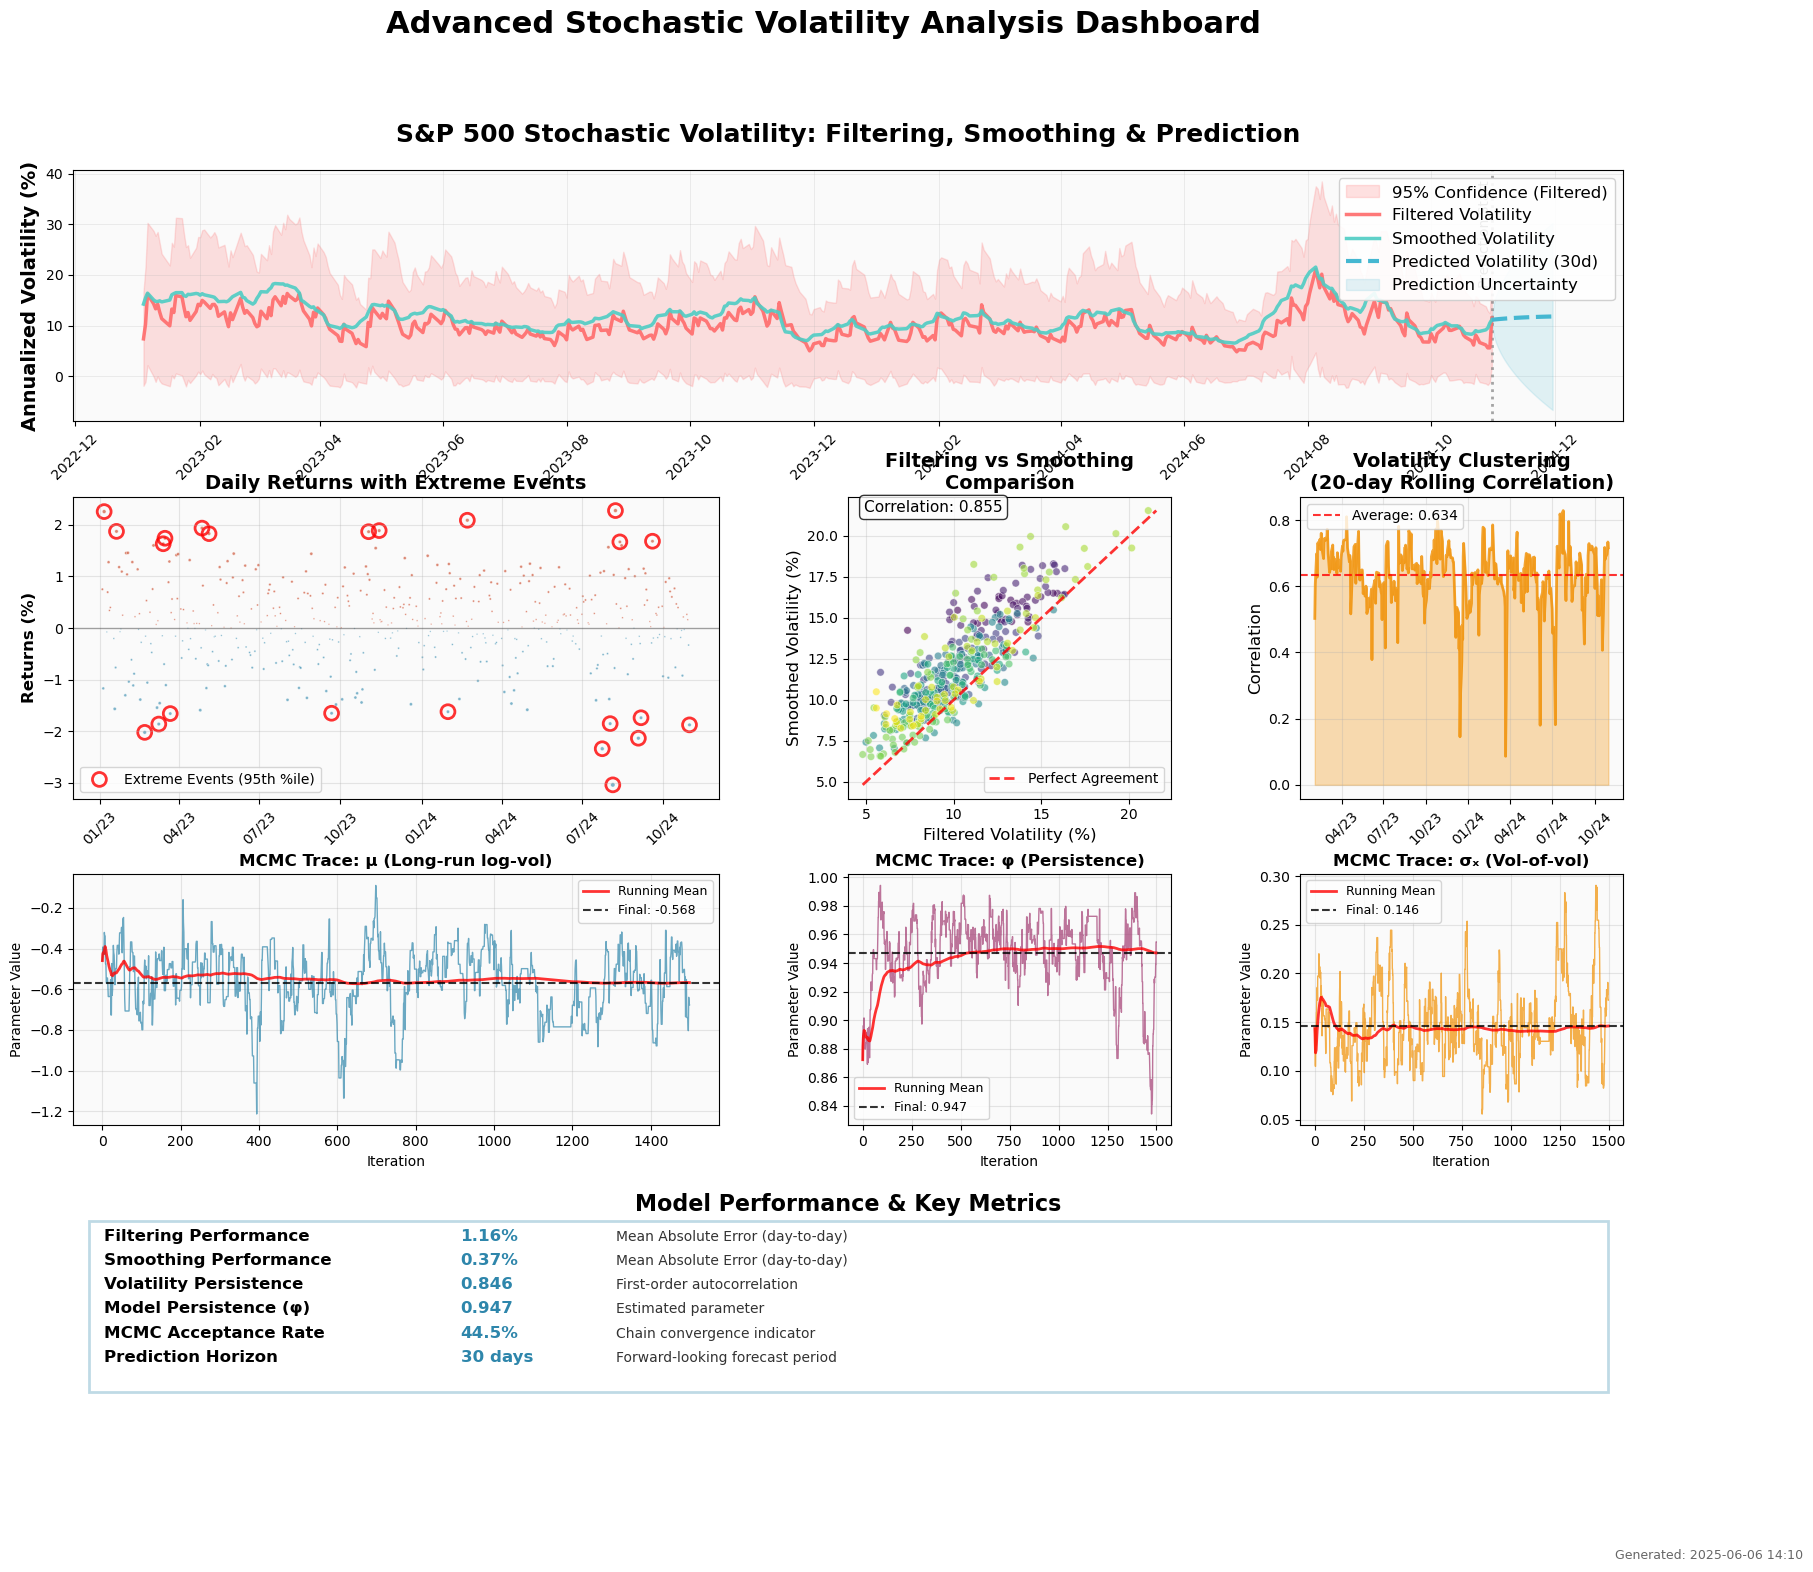

🔍 Creating detailed filtering/smoothing comparison...


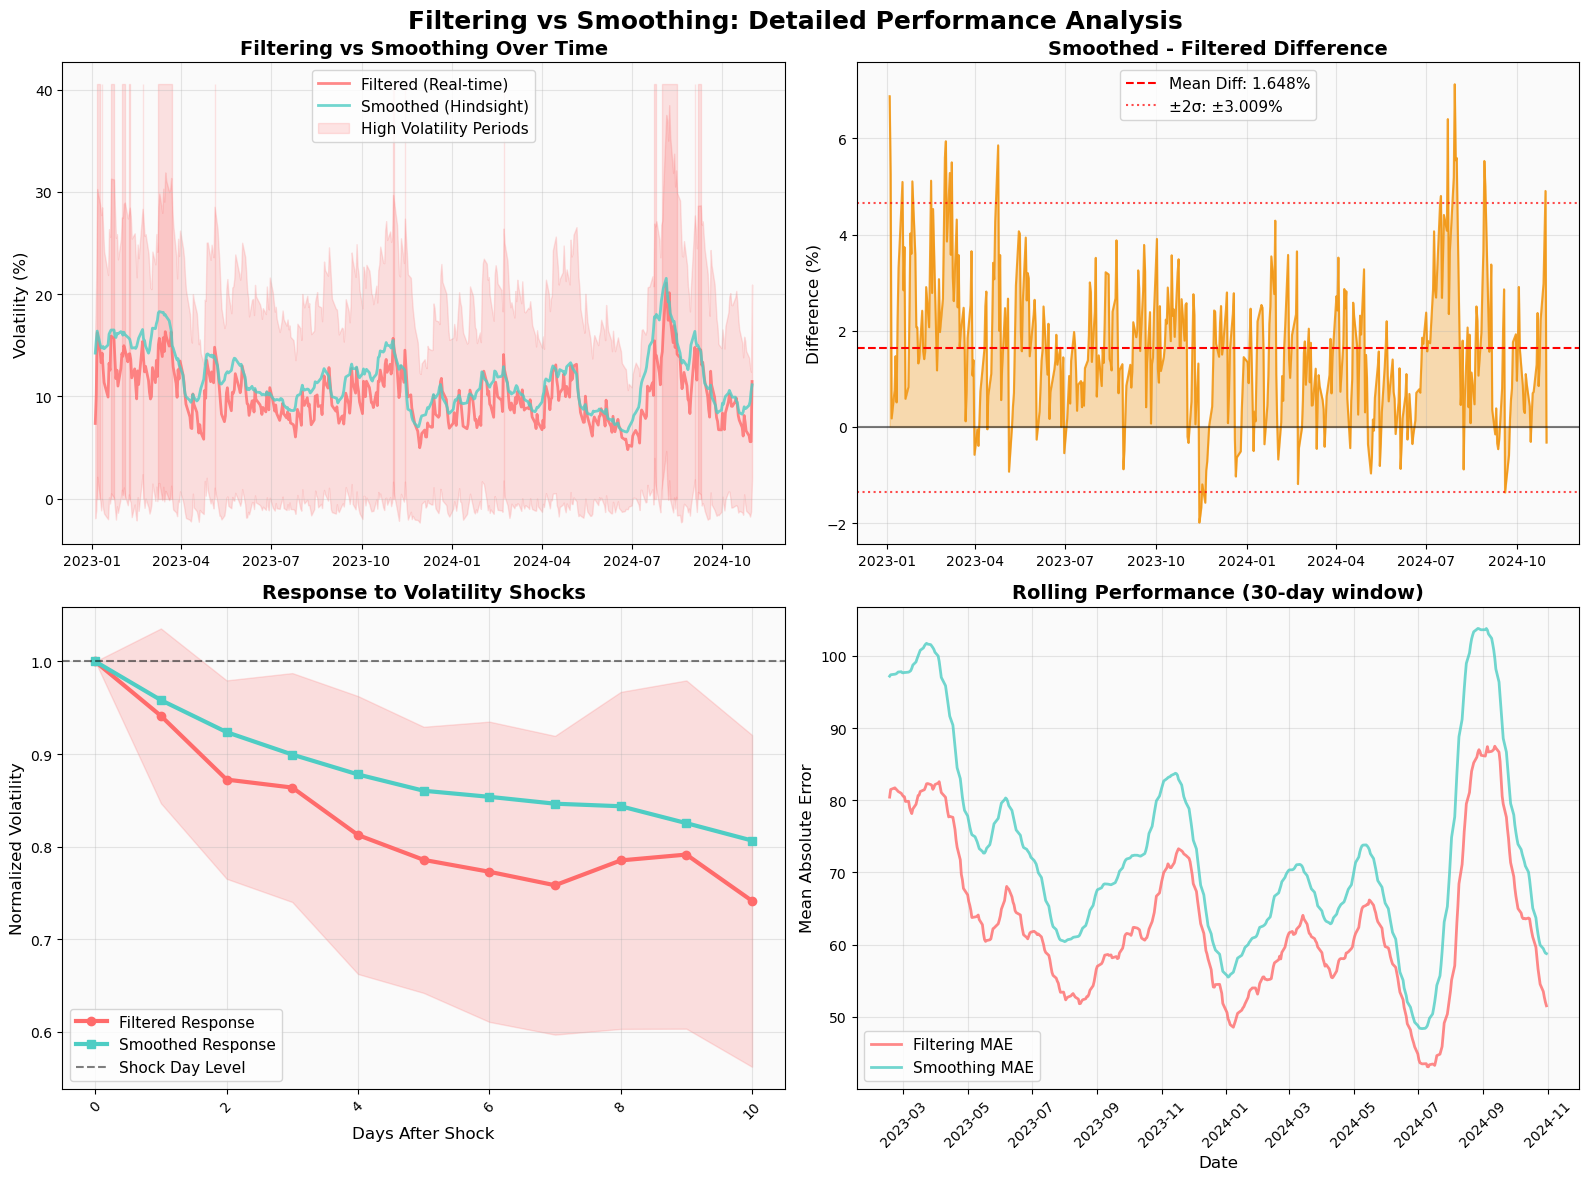

✅ Enhanced visualizations completed!


In [77]:
fig1, fig2 = run_enhanced_visualization(data, filtering_results, smoothing_results, mcmc_results)


## Plot for the presentation

In [78]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set modern styling
plt.style.use('default')
sns.set_palette("husl")

# Custom color palette
COLORS = {
    'primary': '#2E86AB',      # Blue
    'secondary': '#A23B72',    # Purple
    'accent': '#F18F01',       # Orange  
    'success': '#C73E1D',      # Red
    'background': '#F5F5F5',   # Light gray
    'dark': '#1C1C1C',         # Dark gray
    'filter': '#FF6B6B',       # Coral red
    'smooth': '#4ECDC4',       # Teal
    'predict': '#45B7D1',      # Sky blue
    'actual': '#2ECC71',       # Emerald green
    'confidence': '#96CEB4',   # Mint green
    'returns': '#FECA57'       # Golden yellow
}

def create_volatility_plot_with_actual_overlay(data, filtering_results, smoothing_results, 
                                              mcmc_results, future_data=None, prediction_horizon=30):
    """
    Create enhanced volatility plot with actual future data overlay on predictions
    
    Parameters:
    -----------
    data : DataFrame
        Historical data with index as dates
    filtering_results : dict
        Results from filtering process
    smoothing_results : dict
        Results from smoothing process
    mcmc_results : dict
        MCMC estimation results
    future_data : DataFrame, optional
        Actual future data to overlay on predictions (should have 'Returns' column)
    prediction_horizon : int
        Number of days to predict forward
    """
    print("🎨 Creating enhanced volatility visualization with prediction overlay...")
    
    # Extract data
    dates = data.index
    returns = data['Returns']
    vol_filter = filtering_results['vol_estimates']
    vol_smooth = smoothing_results['vol_estimates']
    vol_filter_std = filtering_results['vol_std']
    
    # Generate predictions
    last_vol = vol_smooth[-1]
    phi = mcmc_results['estimates']['phi']['mean']
    mu = mcmc_results['estimates']['mu']['mean']
    sigma_x = mcmc_results['estimates']['sigma_x']['mean']
    
    # Predict future volatility
    pred_dates = pd.date_range(start=dates[-1] + timedelta(days=1), 
                              periods=prediction_horizon, freq='D')
    pred_vol = []
    pred_vol_upper = []
    pred_vol_lower = []
    
    current_log_vol = np.log(last_vol / np.sqrt(252)) * 2
    for i in range(prediction_horizon):
        # Mean reversion to long-run level
        pred_log_vol = mu + phi * (current_log_vol - mu)
        pred_volatility = np.exp(pred_log_vol / 2) * np.sqrt(252)
        
        # Uncertainty grows over time
        uncertainty = sigma_x * np.sqrt(i + 1) * np.exp(pred_log_vol / 2) * np.sqrt(252)
        
        pred_vol.append(pred_volatility)
        pred_vol_upper.append(pred_volatility + 1.96 * uncertainty)
        pred_vol_lower.append(pred_volatility - 1.96 * uncertainty)
        
        current_log_vol = pred_log_vol
    
    # Process actual future data if provided
    actual_future_vol = None
    if future_data is not None and 'Returns' in future_data.columns:
        # Calculate realized volatility from future returns
        # Using a rolling window approach or squared returns
        future_returns = future_data['Returns']
        
        # Simple approach: rolling standard deviation (annualized)
        window = 5  # 5-day rolling window for smoother estimate
        actual_future_vol = future_returns.rolling(window=window, min_periods=1).std() * np.sqrt(252)
        
        # Align with prediction dates
        actual_future_vol = actual_future_vol.reindex(pred_dates[:len(future_data)])
    
    # Create the plot
    fig = plt.figure(figsize=(18, 10))
    ax = plt.gca()
    
    # Set overall style
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#FAFAFA')
    
    # =====================================================================
    # Historical Data
    # =====================================================================
    
    # Plot filtered volatility with confidence bands
    ax.fill_between(dates, 
                    vol_filter - 1.96 * vol_filter_std,
                    vol_filter + 1.96 * vol_filter_std,
                    alpha=0.2, color=COLORS['filter'], 
                    label='95% Confidence (Filtered)', zorder=1)
    
    # Plot main volatility lines
    ax.plot(dates, vol_filter, color=COLORS['filter'], linewidth=2.5, 
            label='Filtered Volatility', alpha=0.9, zorder=3)
    ax.plot(dates, vol_smooth, color=COLORS['smooth'], linewidth=2.5,
            label='Smoothed Volatility', alpha=0.9, zorder=4)
    
    # =====================================================================
    # Predictions
    # =====================================================================
    
    # Combine historical and predicted data for smooth transition
    all_dates = list(dates) + list(pred_dates)
    combined_vol = list(vol_smooth) + pred_vol
    combined_upper = list(vol_smooth) + pred_vol_upper  
    combined_lower = list(vol_smooth) + pred_vol_lower
    
    # Prediction line and confidence
    pred_start_idx = len(dates) - 1
    ax.plot(all_dates[pred_start_idx:], combined_vol[pred_start_idx:], 
            color=COLORS['predict'], linewidth=3, linestyle='--',
            label=f'Predicted Volatility ({prediction_horizon}d)', zorder=5)
    ax.fill_between(all_dates[pred_start_idx:], 
                    combined_lower[pred_start_idx:],
                    combined_upper[pred_start_idx:],
                    alpha=0.15, color=COLORS['predict'], 
                    label='Prediction Uncertainty', zorder=2)
    
    # =====================================================================
    # Actual Future Data Overlay
    # =====================================================================
    
    if actual_future_vol is not None:
        # Plot actual volatility
        valid_dates = actual_future_vol.index[~actual_future_vol.isna()]
        valid_vol = actual_future_vol.dropna()
        
        ax.plot(valid_dates, valid_vol, 
                color=COLORS['actual'], linewidth=3, 
                marker='o', markersize=6, markeredgecolor='white',
                label='Actual Realized Volatility', zorder=6)
        
        # Calculate and display prediction errors
        if len(valid_vol) > 0:
            # Align predictions with actual data
            aligned_pred = pred_vol[:len(valid_vol)]
            aligned_actual = valid_vol.values
            
            # Calculate metrics
            mae = np.mean(np.abs(aligned_pred - aligned_actual))
            rmse = np.sqrt(np.mean((aligned_pred - aligned_actual)**2))
            mape = np.mean(np.abs((aligned_pred - aligned_actual) / aligned_actual)) * 100
            
            # Add metrics box
            metrics_text = f'Prediction Performance:\nMAE: {mae:.2f}%\nRMSE: {rmse:.2f}%\nMAPE: {mape:.1f}%'
            ax.text(0.02, 0.98, metrics_text, 
                   transform=ax.transAxes, fontsize=11,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                            edgecolor=COLORS['actual'], alpha=0.9))
    
    # =====================================================================
    # Styling and Annotations
    # =====================================================================
    
    # Add vertical line to separate historical from predicted
    ax.axvline(x=dates[-1], color='gray', linestyle=':', alpha=0.7, linewidth=2)
    ax.text(dates[-1], ax.get_ylim()[1] * 0.95, 'Prediction Start', 
            rotation=90, va='top', ha='right', fontsize=10, alpha=0.7)
    
    # If we have actual data, mark where it ends
    if actual_future_vol is not None and len(valid_vol) > 0:
        last_actual_date = valid_dates[-1]
        ax.axvline(x=last_actual_date, color=COLORS['actual'], 
                  linestyle=':', alpha=0.5, linewidth=2)
        ax.text(last_actual_date, ax.get_ylim()[1] * 0.85, 'Last Actual Data', 
               rotation=90, va='top', ha='right', fontsize=10, 
               color=COLORS['actual'], alpha=0.7)
    
    # Title and labels
    title = 'S&P 500 Stochastic Volatility: Filtering, Smoothing & Prediction'
    if actual_future_vol is not None:
        title += ' with Actual Overlay'
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.set_ylabel('Annualized Volatility (%)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    
    # Grid and legend
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add model parameters box
    param_text = f'Model Parameters:\nφ (Persistence): {phi:.3f}\nμ (Long-run): {mu:.3f}\nσₓ (Vol-of-vol): {sigma_x:.3f}'
    ax.text(0.98, 0.02, param_text, 
           transform=ax.transAxes, fontsize=10,
           horizontalalignment='right', verticalalignment='bottom',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                    edgecolor=COLORS['primary'], alpha=0.9))
    
    # Add timestamp
    plt.figtext(0.99, 0.01, f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}', 
               ha='right', va='bottom', fontsize=9, alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage function
def run_volatility_prediction_analysis(data, filtering_results, smoothing_results, 
                                     mcmc_results, future_data=None):
    """
    Run volatility visualization with optional actual data overlay
    
    Example:
    --------
    # Without actual future data (pure prediction)
    fig = run_volatility_prediction_analysis(data, filtering_results, 
                                           smoothing_results, mcmc_results)
    
    # With actual future data overlay
    fig = run_volatility_prediction_analysis(data, filtering_results, 
                                           smoothing_results, mcmc_results, 
                                           future_data=actual_future_df)
    """
    print("🚀 Running Volatility Prediction Analysis")
    print("=" * 60)
    
    if future_data is not None:
        print(f"✓ Including actual future data overlay ({len(future_data)} days)")
    else:
        print("→ No actual data provided - showing predictions only")
    
    fig = create_volatility_plot_with_actual_overlay(
        data, filtering_results, smoothing_results, mcmc_results, 
        future_data=future_data, prediction_horizon=30
    )
    
    print("✅ Visualization completed!")
    
    return fig

🎨 Creating enhanced volatility visualization with prediction overlay...


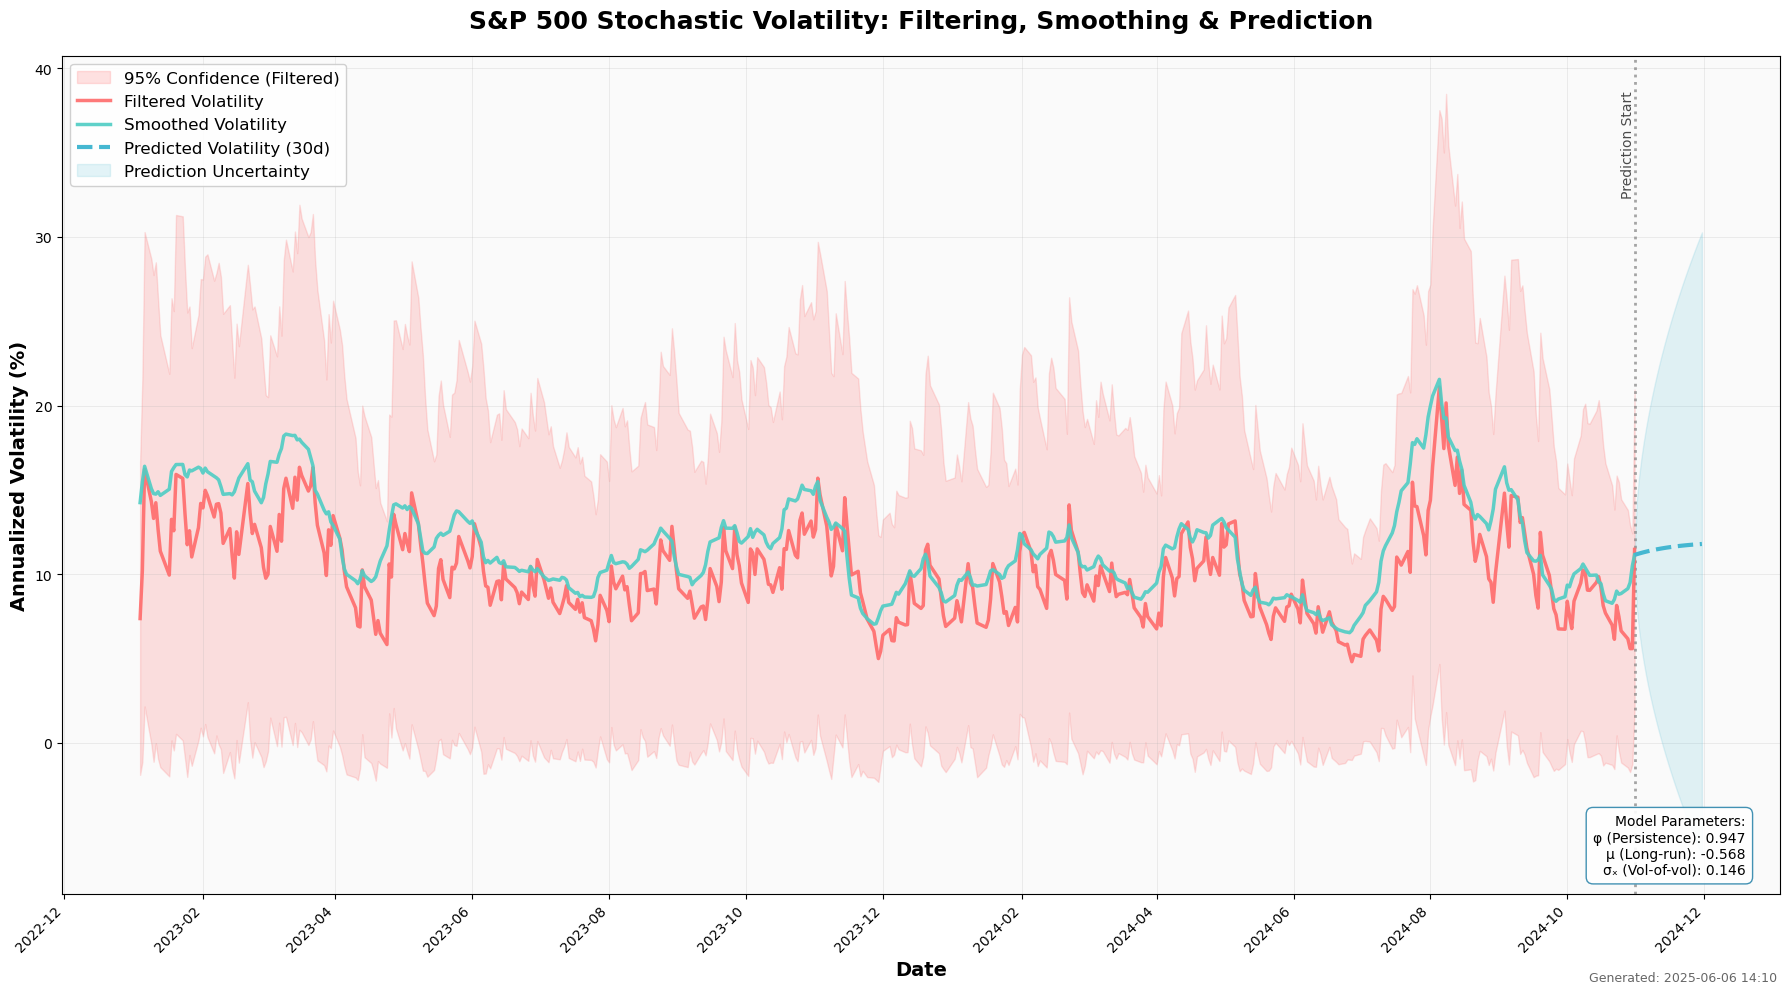

In [79]:
f = create_volatility_plot_with_actual_overlay(data, filtering_results, 
                                       smoothing_results, mcmc_results)